In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/1_BotArtist/russo-ukrainian-war-10M-profiles.csv")

In [5]:
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (10929533, 52)


,age,description_urls,description_mentions,description_hashtags,screen_name_sim,statuses,statuses_by_age,following,following_by_age,followers,...,name_entropy,has_location,profile_url,total_urls,foll_friends,verified,protected,uid,label,proba
0,786.0,0,0,0,0.200000,1215,1.545802,258,0.328244,80,...,2.271869,1,1,1,0.310078,0,0,uidb46b767fa5e2d342baaf2fc457a8740e3822837cd22...,human,68
1,4722.0,0,0,0,0.333333,3332,0.705633,49771,10.540237,128211,...,1.609438,0,0,0,2.576018,0,0,uidc43ed59435d39c26a0a3e972241710175492d68024e...,human,66
2,3410.0,0,0,0,0.411765,178614,52.379472,95,0.027859,1642,...,2.441015,1,0,0,17.284211,0,0,uida3eabc8386c783711bca4076378810ab5396082a6e0...,human,99
3,4266.0,2,0,0,0.857143,207601,48.664088,8,0.001875,3911749,...,2.302585,1,1,3,488968.625000,1,0,uidde3a6fd227120315235df6807eb63b035159a98b771...,human,99
4,2083.0,0,0,0,0.692308,1271,0.610178,138,0.066251,30,...,2.351673,0,0,0,0.217391,0,0,uid9dcc848e0b07d43d9df616f4969c72d84d863c34e88...,bot,54


In [6]:
# Basic info
df.info()

# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10929533 entries, 0 to 10929532
Data columns (total 52 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   age                     float64
 1   description_urls        int64  
 2   description_mentions    int64  
 3   description_hashtags    int64  
 4   screen_name_sim         float64
 5   statuses                int64  
 6   statuses_by_age         float64
 7   following               int64  
 8   following_by_age        float64
 9   followers               int64  
 10  followers_by_age        float64
 11  listed                  int64  
 12  listed_by_age           float64
 13  profile_image           int64  
 14  description_upper_len   int64  
 15  description_lower_len   int64  
 16  description_digit_len   int64  
 17  description_spec_len    int64  
 18  description_upper_pcnt  float64
 19  description_lower_pcnt  float64
 20  description_digit_pcnt  float64
 21  description_spec_pcnt   float

In [7]:

# Summary statistics for numerical features
print("\nSummary statistics:")
print(df.describe().T)




Summary statistics:
                             count          mean            std   min  \
age                     10929533.0  1.985266e+03    1647.581753   0.0   
description_urls        10929533.0  4.246815e-02       0.247713   0.0   
description_mentions    10929533.0  8.819407e-03       0.155272   0.0   
description_hashtags    10929533.0  2.414037e-02       0.339279   0.0   
screen_name_sim         10929533.0  4.476854e-01       0.300895   0.0   
statuses                10929533.0  1.411933e+04   44191.322833   0.0   
statuses_by_age         10929533.0  1.172147e+01      43.407355   0.0   
following               10929533.0  7.760640e+02    3361.368815   0.0   
following_by_age        10929533.0  1.780805e+00      11.045350   0.0   
followers               10929533.0  3.286531e+03  182082.271002   0.0   
followers_by_age        10929533.0  2.108980e+00     800.942224   0.0   
listed                  10929533.0  1.627956e+01     389.508591   0.0   
listed_by_age           109295

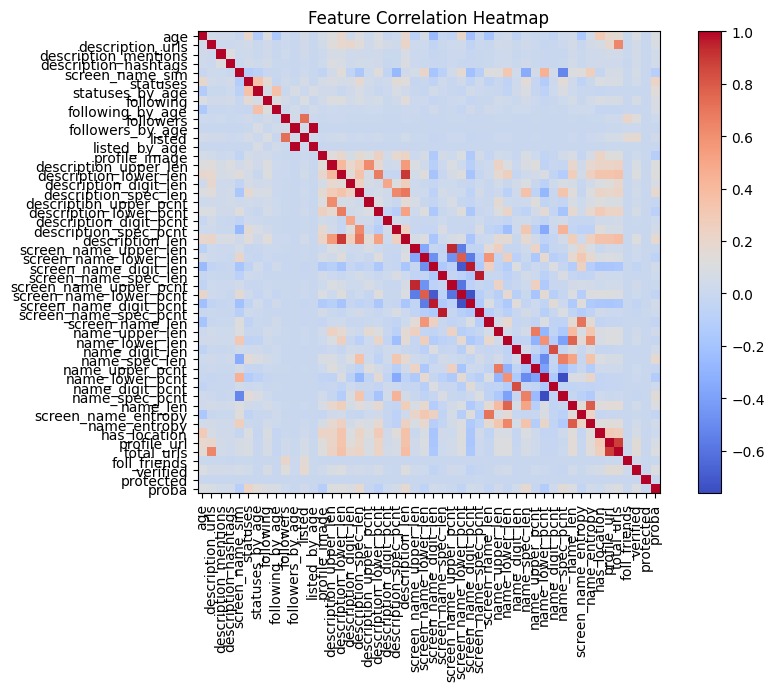

In [8]:
# Example correlations
num_cols = df.select_dtypes(include="number").columns
corr = df[num_cols].corr()
plt.figure(figsize=(10, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature Correlation Heatmap")
plt.show()

Class counts:
 label
human    6707355
bot      4222178
Name: count, dtype: int64

Class percentages:
 label
human    61.37
bot      38.63
Name: proportion, dtype: float64


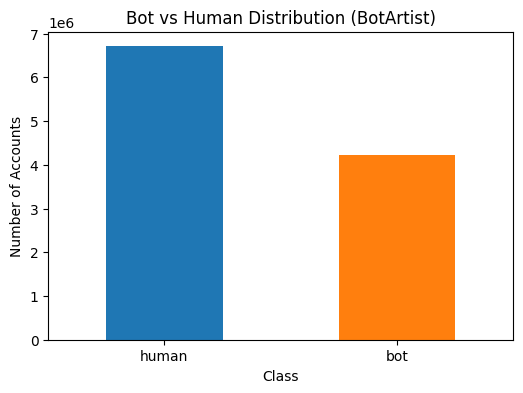

In [9]:
class_counts = df["label"].value_counts()
class_perc = df["label"].value_counts(normalize=True) * 100

print("Class counts:\n", class_counts)
print("\nClass percentages:\n", class_perc.round(2))

# Plot
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e"])
plt.title("Bot vs Human Distribution (BotArtist)")
plt.xlabel("Class")
plt.ylabel("Number of Accounts")
plt.xticks(rotation=0)
plt.show()